#**Face Detection per fotocamere digitali**
In questo progetto realizzato da me, Alessio Feudo, nell'ambito del Master in Data Science erogato da ProfessionAI, ho affrontato un task di **Face Datection**. In particolare, lo scopo è stato realizzare un modello in grado di rilevare volti in immagini stile selfie, utile nell'ambito di fotocamere digitali.
Il dataset utilizzato non è fornito, per cui ho personalmente scelto immagini adatte per addestrare il modello. Per il modello stesso, ho confrontato due approcci: il primo basato sulle **HOG** features in combinazione con un modello **Support Vector Machine**, mentre il secondo basato sulla **Haar cascade**, già disponibile in forma preaddestrata nella libreria **OpenCV**. Entrambi i metodi costituiscono approcci 'classici' alla face detection [[1](https://robotcopper.github.io/Machine_Learning/HoG_and_SVM), [2](https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features), [3](https://arxiv.org/abs/1406.2419), [4](https://docs.opencv.org/4.x/d2/d99/tutorial_js_face_detection.html), [5](https://medium.com/@utkrisht14/face-detection-using-haar-cascade-algorithm-267751b43240)].

###**Dataset**

Per addestrare il modello HOG+SVM ho considerato un dataset risultante dall'unione di due differenti insiemi di dati [[6](https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset)] e [[7](https://www.kaggle.com/datasets/arnaud58/landscape-pictures)]: il primo contenente immagini di volti singoli (classe positiva), il secondo immagini di paesaggi (classe negativa), presi in numero bilanciato (NOTA: nel dataset con volti ho considerato solo quelli reali). Dato che le immagini della classe positiva contengono volti in primo piano, il dataset si presta bene per l'addestramento, in quanto tramite le immagini di soli volti, il modello ha modo di 'imparare' le features di HOG inerenti, senza disturbi da parte di altri oggetti/animali presenti.

Inoltre, per aiutare l'addestramento i dati di training sono alterati in termini di rotazioni e variazioni di contrasto, così da sottoporre all'SVM un panorama più generale. Questa scelta dovrebbe portare a ridurre il rischio di overfitting, aiutando il modello a generalizzare.

###**Features di HOG**

Per poter addestrare un modello a riconoscere pattern visuali, si devono tradurre in termini matematico/vettoriali le immagini. L'approccio delle HOG features (Histogram of Oriented Gradients) [[8](https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_hog.html), [9](https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d)] consiste nell'analizzare la distribuzione delle orientazioni dei gradienti, che in un certo senso tracciano i bordi degli oggetti presenti. Ciò che si fa è considerare l'immagine originale e suddividerla in celle di dimensione fissa (es. 8x8). In ogni cella dell'immagine si calcolano i gradienti dell'intensità dei pixel (modulo e direzione) nella regione data. Si va a studiare la distribuzione dei gradienti nella cella andando a costruire l'istogramma delle orientazioni con un numero di bin da fissare, dove ogni bin rappresenta un intervallo di orientazione in unità angolari. Ogni gradiente contribuisce al valore del bin in modo tale che l'altezza finale del bin i è data dalla somma dei moduli dei gradienti che ricadono in quel bin di orientazione. Dopo questa analisi, le celle sono raggruppate in blocchi (es. 2x2), concatenando i vari istogrammi delle celle, andando anche ad uniformare l'informazione tramite normalizzazione delle celle sulla dimensione del blocco. Al termine del processo, ogni immagine sarà rappresentata da un unico vettore di features di HOG.

Per estrarre correttamente le features di HOG, è necessario trasformare prima l'immagine in scala di grigi, così da individuare un solo gradiente per ogni cella, invece di un gradiente per ogni colore (canale) presente se l'immagine fosse a colori. Questo riduce anche il costo computazionale del problema.




###**Support Vector Machine (SVM)**
Una volta prodotto un vettore di features di HOG, questo può essere dato ad un modello di ML per la classificazione.
Il modello utilizzato per classificare le immagini è un support vector classifier, rientrante nella famiglia dei modelli SVM. Questi sono modelli di apprendimento supervisionato che si basano sul trovare l'iperpiano che meglio separa le due classi. In particolare, basano l'apprendimento sul distinguere i dati più ambigui/incerti delle due classi, tramite l'individuazione dei vettori di supporto che definiscono i limiti interni tra le classi. In letteratura l'SVM è solitamente abbinato alla classificazione con features di HOG, questo perchè riesce a gestire bene vettori di features molto lunghi, può recuperare decision boundary anche non lineari e può essere ben addestrato anche con pochi dati.

###**Il problema dei rettangoli ridondanti**
Dopo aver classificato una data immagine con SVM, si procede a delineare i rettangoli che racchiudono i volti trovati. Il metodo ususale consiste nell'utilizzare una sliding window grande come la finestra su cui l'SVM è stato addestrato [[10](https://www.cs.utoronto.ca/~fidler/slides/CSC420/lecture17.pdf)]. Si fa scorrere la sliding window sull'immagine in cui si vogliono trovare volti e se la classificazione è positiva, la data finestra identifica un rettangolo in cui è possibile trovare un volto. Dato che però la finestra di addestranento dell'SVM ha dimensioni fisse, per adattarla a immagini variegate in dimensioni, si usa un approccio a piramide, dove l'immagine originale viene scalata. Questo permette di rintracciare volti di dimensioni diverse tra loro. Capita quindi che in tale processo lo stesso volto presente dia classificazione positiva su finestre di grandezza diversa, ma tutte legate alla stessa fonte, creando ridondanza. Per mitigare la ridondanza, si usano due approcci differenti, di cui uno basato su un modello di **clustering**.

###**Haar cascade**

A margine della precedente analisi, si confrontano i risultati ottenuti, anche in termini di efficienza, con quelli estraibili utilizzando un approccio a cascata du Haar, che consiste nell'utilizzare una cascata di classificatori per individuare pattern sepcifici in termini di intensità di pixels vicini.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import zipfile
from skimage.feature import hog
from skimage.transform import pyramid_gaussian, rotate, rescale, resize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, RocCurveDisplay, log_loss, classification_report
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
import seaborn as sns
import cv2
from imutils.object_detection import non_max_suppression
from joblib import dump
import psutil, os, time

Come introdotto, il dataset utilizzato nel progetto è fatto dall'unione di un dataset contenente volti e uno contenente paesaggi. Entrambi sono scaricati da kaggle con l'apposita API key.

In [ ]:
def upload_data():
  '''
  The function uploads the chosen datasets via kaggle API.
  '''
  from google.colab import files
  files.upload()

  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle datasets download -d kaustubhdhote/human-faces-dataset #dataset with faces
  zipfile.ZipFile("human-faces-dataset.zip").extractall("dataset_faces")


  !kaggle datasets download -d arnaud58/landscape-pictures  # dataset without faces (landscape)
  zipfile.ZipFile("landscape-pictures.zip").extractall("dataset_nofaces")

upload_data()


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/114M [00:00<?, ?B/s]
100% 114M/114M [00:00<00:00, 1.44GB/s]
Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
License(s): CC0-1.0
 94% 583M/620M [00:03<00:00, 177MB/s]
100% 620M/620M [00:06<00:00, 96.3MB/s]


##**Estrazione immagini**

Le immagini precedentemente scaricate da kaggle vengono ora convertite in scala di grigi e riscalate senza deformarle, in modo da rientrare in una dimensione di 128x256 pixels, scelta in modo da essere ragionevomente risoluta per individuare pattern di volti, ma allo stesso tempo non troppo grande, per evitare di perdere possibili volti più piccoli. Al termine di queste operazioni, le immagini sono trasformate in array numpy. Dato che il dataset finale è l'unione di due sotto datasets, ci si assicura il bilanciamento delle classi, considerando lo stesso numero di immagini per classe positiva e negativa.

Le classi target sono assegnate alle immagini in modo da avere 0 per classe negativa (no face) e 1 per positiva (face).

In [ ]:
def resize_in_scale(img, target_size=(128,256)):
    '''
    The function resizes an input image to match a required target size.
    Args:
        - img (obj PIL.Image): the input image to resize
        - target_size (tuple): the output size to obtain

    Returns:
        - obj PIL.Image: the processed image
    '''

    target_w, target_h = target_size # extract the target size
    w, h = img.size # extract the original image size
    scale = max(target_w/w, target_h/h)  # scale factor to resize without deformations
    new_w, new_h = int(w*scale), int(h*scale) #new width and height of the image
    img_resized = img.resize((new_w, new_h), resample=Image.LANCZOS) #Image.LANCZOS allows high quality resizing

    #After resizing, the image can be larger (in width or height) with respect to the target size.
    #For this reason, a crop is performed, in order to cut only the central part of the image,
    #usually containing the face in the positive target data.

    # crop to match target size
    if (new_w, new_h)!=target_size:
      x_left_side = (new_w - target_w)//2   # x coordinate of the left border
      y_upper_side = (new_h - target_h)//2   # y coordinate of the upper border
      x_right_side = x_left_side + target_w   # x coordinate of the right border
      y_lower_side = y_upper_side + target_h   # y coordinate of the lower border
      img_resized = img_resized.crop((x_left_side, y_upper_side, x_right_side, y_lower_side))

    return img_resized



def image_to_array(dir_path):
  '''
  The function extracts images from a given directory and convert them in numpy arrays.
  It also shows one of the recovered images.

  Args:
      - dir_path (str): directory path where images are stored

  Returns:
      - np.ndarray: numpy array storing the numpy images
  '''

  paths = []  #empty list to store image paths

  #the directory is analyzed and one gets: root (current directory path), dirs (subdirectories)
  #and files (files stored in root directory). The loop analyzes all subdirectories recursively.
  for root, dirs, files in os.walk(dir_path):
      for file in files: # loop over all files stored in root directory
          if file.endswith((".jpg", ".jpeg", ".png")):  # filter only files which represent images
              paths.append(os.path.join(root, file)) #add the file (image) path to paths list

  print(f"Images found: {len(paths)}")
  image_array = [] # empty image list, to contain numpy images
  for path in paths: #loop over image paths
      img = Image.open(path).convert("L") #each image is opened and converted in greyscale
      img=resize_in_scale(img) #the resize_in_scale function is applied
      img=np.array(img)  #image as numpy array
      image_array.append(img)

  image_array = np.array(image_array)
  print(image_array.shape)

  # a specific image of the final image_array is plotted
  plt.imshow(image_array[4000], cmap='gray')
  return image_array

Images found: 4319
(4319, 256, 128)


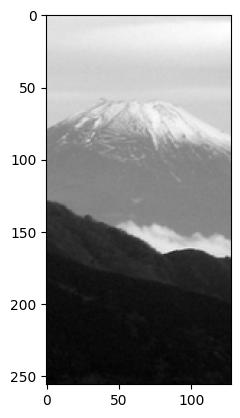

In [ ]:
# Directory paths defintion
faces_dir = "dataset_faces/Human Faces Dataset/Real Images" # directory storing images with faces
nofaces_dir= "dataset_nofaces" # directory storing images without faces (landscapes)
# Images without faces
nofaces_array=image_to_array(nofaces_dir) # extraction of images and transformation into numpy arrays
len_nofaces=len(nofaces_array) # array without faces length

Images found: 5000
(5000, 256, 128)


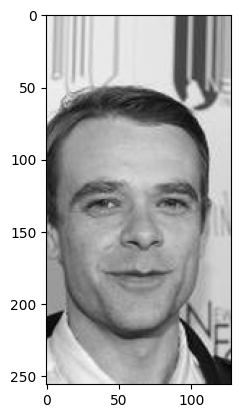

In [ ]:
# Images with faces
faces_array=image_to_array(faces_dir) # extraction of images and transformation into numpy arrays
faces_array_subset=faces_array[:len_nofaces] # the faces datavector is limited to the length of
                                             # the nofaces one, which is smaller


In [ ]:
#target creation
y_nofaces=np.zeros(len_nofaces) # nofaces images are labelled with zeros
y_faces=np.ones(len_nofaces) # faces images labelled with ones



In [ ]:
# Complete dataset creation: faces and nofaces merging
x = np.concatenate([faces_array_subset, nofaces_array], axis=0) # concatenating faces and nofaces images
y = np.concatenate([y_faces, y_nofaces]) # concatenating conresponding targets

print(y.shape, x.shape)

(8638,) (8638, 256, 128)


###**Estrazione features di HOG e processing del dataset**

A questo punto il dataset viene diviso in set di training, validation e test per poi procedere ad addestrare il modello SVM, utilizzando il validation set per il fine tuning. A tal fine, per evitare overfitting (che si è visto essere presente) si adottano diverse tecniche: i dati nel set di training vengono sottoposti alla funzione 'data_augmentation' che si occupa di alterare l'immagine originale modificandone il contrasto o l'orientazione [[11](https://stats.stackexchange.com/questions/562442/how-to-perform-data-augmentation-with-traditional-machine-learning-algorithms)]. Queste variazioni non sono drastiche: infatti introdurre casi estremi con orientazioni/contrasti irrealistici, avrebbe l'effetto di produrre gradienti di HOG troppo alterati, portando a peggiorare le performance del classificatore. Per questo si ruotano le immagini del 10% e si varia il contrasto del 20%.
Una volta alterate le immagini, si calcolano le features di HOG tramite apposita funzione, selezionando per i relativi iperparametri i valori di:
- n. bin istogramma=9 (le orientazioni sono comprese tra 0 e 180 gradi);
- grandezza celle: 8x8 pixels;
- celle per blocco: 2x2;

in accordo con quanto riportato in [[12](https://www.warse.org/IJETER/static/pdf/file/ijeter244892020.pdf)] e nelle fonti precedenti.


Per completezza, si può ricordare come più bins e/o celle più piccole conducano ad avere un numero crescente di features, e quindi maggior rischio di overfiting.
Oltre ciò, più features vuol dire anche maggiore spazio in memoria, e dato che il modello dovrà lavorare su fotocamere con risorse come la RAM limitate, si cerca di ridurre il numero di features utilizzate in HOG, settando gli iperparametri in alto.

In [ ]:
#train_val split
x_train_tot, x_test, y_train_tot, y_test = train_test_split(x, y, test_size=0.2) # 20% for test set
x_train, x_val, y_train, y_val = train_test_split(x_train_tot, y_train_tot, test_size=0.1) # validation set extraction
scaler=StandardScaler() #instantiation of standard scaler
pca=PCA(n_components=0.90) #instantiation of principal component analysis in order to reduce dimensionality of the hog features vector,
                           #preserving 90% of variance

In [ ]:
#data augmentation
def data_augmentation(img):
  '''
  The function alter images, in order to introduce diversity in the dataset in terms of brightness and orientation.

  Args:
      - img (np.ndarray): image to alter

  Returns:
      - np.ndarray: the altered image
  '''
  #modi_list contains the possible modifications to apply on the image
  modi_list=[
        img, #no modification
        rotate(img, 10, mode='edge'), # 10 degrees rotation (counterclockwise), mode='edge' fills empty edges with the value of the nearest image border
        rotate(img, -10, mode='edge'), # 10 degrees rotation (clockwise)
        np.clip(img * 1.2, 0, 255), # enhance brightness of 20% for each pixel, always rescaling to the range 0-255
        np.clip(img * 0.8, 0, 255) # decrease brightness
        ]
  k = np.random.randint(len(modi_list)) # random selection of one of the possible modifications
  img_varied=modi_list[k] # apply the selected modification
  return img_varied

In [ ]:
def hog_features_extractor(img_array):
  '''
  The function computes the HOG features for each image of the image array passed in input.

  Args:
      - img_array (np.ndarray): input array containing images

  Returns:
      - np.ndarray: matrix containing a HOG features vector for each image
  '''
  features_list=[] # empty list to store images in terms of HOG features
  #check to ensure same shape for all images passed
  img_shape=img_array[0].shape
  assert all(img.shape==img_shape for img in img_array), "Images have different shapes!"
  #HOG feature extraction
  for img in img_array:
    hog_features=hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm='L2-Hys')
    features_list.append(hog_features)
  return np.array(features_list)

###**Standardizzazione e PCA**
Una volta ottenute le features di Hog che sono già internamente normalizzate su ogni blocco di immagine data, si applica anche la standardizzazione tra le diverse immagini, così da uniformare i valori delle features nelle varie immagini, che possono risultare diverse a causa di luminosità differenti, ad esempio.

Dopo la standardizzazione si procede applicando una Principal Component Analysis (PCA), utile a ridurre la dimensionalità dello spazio delle features, velocizzando il training dell'SVM e mitigando unteriormente l'overfitting, data la riduzione del numero di features finali. Per la PCA si sceglie di preservare il 90% della varianza delle features originali.

In [ ]:

x_train=np.array([data_augmentation(img) for img in x_train]) #apply the data_augmentation function

#HOG features extraction
x_train=hog_features_extractor(x_train)
x_val=hog_features_extractor(x_val)
x_test=hog_features_extractor(x_test)

print(f'\nx_train shape before PCA: {x_train.shape}')

# StandardScaler application
x_train=scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)

#PCA application
x_train=pca.fit_transform(x_train)
x_val=pca.transform(x_val)
print(f'\nx_train shape after PCA: {x_train.shape}')


x_train shape before PCA: (6219, 16740)

x_train shape after PCA: (6219, 1982)


###**Metriche di classificazione**
Le funzioni di seguito riportate analizzano il rendimento del modello SVM (che sarà a breve addestrato) sui vari set di training, validation e test, a seconda dei casi. In particolare calcolano la matrice di confusione, la ROC, la learning curve e altre metriche di classificazione.

In [ ]:
def confusion(y_true, y_pred, name):
  '''
   This function shows the confusion matrix of the model.
   Args:
       - y_true (np.ndarray): true target
       - y_pred (np.ndarray): predicted target
       - name (str): string to insert in the plot title
  '''

  cm=confusion_matrix(y_true, y_pred)
  # confusion matrix as dataframe
  df_cm=pd.DataFrame(cm, index=['True Negative','True Positive'], columns=['Predicted Negative','Predicted Positive'])
  # confusion matrix heatmap
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(f"CONFUSION MATRIX-{name}")
  plt.show()


def evaluate_model(x_train, y_train, x_test, y_test, model, name, thresh=0.50, learning_c=False):
  '''
  The function evaluates the input model through many classification metrics.
  Args:
      - x_train (np.ndarray): train samples
      - y_train (np.ndarray): train true target
      - x_test (np.ndarray): test/val smaples
      - y_test (np.ndarray): test/val true target
      - model (obj): model to evaluate
      - name (str): dataset name to insert in plots
      - thresh (float): classification threshold. Default: 0.50
      - learning_curve (bool): flag to enable learning curve computation and plot
  '''
  # Predicted proba on trainig and test/val set
  y_prob_train=model.predict_proba(x_train)
  y_prob_test=model.predict_proba(x_test)

  # Model predictions on training and test/val
  y_pred_train=np.where(y_prob_train[:,1]>thresh,1,0)
  y_pred_test=np.where(y_prob_test[:,1]>thresh,1,0)

  #log loss train and test/val
  print(f"Log_loss_train: {round(log_loss(y_train, y_prob_train),3)}\nLog_loss_test: {round(log_loss(y_test, y_prob_test),3)}\n")
  #classification report train and test/val
  print(f"CLASSIFICATION REPORT TRAIN\n{classification_report(y_train, y_pred_train)}")
  print(f"CLASSIFICATION REPORT {name}\n{classification_report(y_test, y_pred_test)}")

  #plot confusion matrix train and test/val
  confusion(y_train, y_pred_train, 'TRAIN')
  confusion(y_test, y_pred_test, name)

  #plot Roc and AUC, train and test/val
  fig, ax = plt.subplots() #same figure for train and test/val, passing the same axis, ax.
  roc_train=RocCurveDisplay.from_estimator(model, x_train, y_train, ax=ax, name='ROC training')
  roc_test=RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax, name=f'ROC {name.lower()}')
  plt.show()

  # Learning curve
  # StratifiedKFold to build folds used by cross validation, such as in each fold the target distribution is the same as in the whole dataset.
  if learning_c==True:
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)
    train_sizes = np.linspace(0.2, 1.0, 5) #learning curve will fit the model on 5 data subsets.
    train_size_abs, train_scores, test_scores=learning_curve(model,
                                                           x_train,
                                                           y_train,
                                                           cv=cv,
                                                           train_sizes=train_sizes,
                                                           n_jobs=-1,
                                                           scoring='recall', # lerning curve will rely on recall
                                                           error_score='raise',
                                                           )
    #learning curve plot
    plt.xlabel('Samples')
    plt.ylabel('Recall')
    plt.plot(train_size_abs, train_scores.mean(axis=1), label='Learning curve training')
    plt.plot(train_size_abs, test_scores.mean(axis=1), label=f'Learning curve {name.lower()}')
    plt.legend()
    plt.show()

###**Addestramento SVM e fine tuning**

In questa sezione si procede con l'addestramento del modello SVM, andando prima di tutto a ricercare gli iperparametri adatti, testando tramite un halving grid search(per velocizzare la ricerca) due tipi di kernel (linear e rbf), e diversi valori per i parametri C e gamma (quest'ultimo presente solo con kernel rbf). La metrica di valutazione è l'accuracy e il modello estratto come migliore è testato sul set di validation.

Una volta trovato il modello migliore, questo viene riaddestrato sui set di training+validation e verificato sul test set. Dato che il modello presenta metriche di classificazione pari all'unità, si cerca di mitigare ulteriormente l'overfitting adottando il valore del parametro C (legato alla regolarizzazione) pari a C=0.01, invece di C=0.1 come emerso dal fine tuning.

In [ ]:
#svm classifier
svm=SVC()

#To find the best hyperparameters, HalvingGridSearch is applied. Two parameter grids are built, depending on the kernel adopted.
param_grid=[
    {'kernel':['rbf'],
    'C':[0.01, 0.1, 1],  #regularization: small->more general model, big->overfitting risk
    'gamma':[0.001, 0.01, 0.1]}, #weight given to each training point to built decision boundary. Only for rbf kernel.

    {'kernel':['linear'],
    'C':[0.01, 0.1, 1]}
    ]

# Halving Grid search
halving_search=HalvingGridSearchCV(
    estimator=svm, # ML model to fine tune
    param_grid=param_grid, # parameters values to investigate
    factor=2, # n. of candidates (hyperpar. combinations) discarded at each step
    scoring='accuracy', # metric used to evaluate the model
    cv=3, # n. of folds to compute cross validation
    verbose=1, # enables verbose mode
    n_jobs=1 # no parallelization.(NOTE: paralleliz. is not used since it saturates RAM)
)

# model fit on train data: result is the best model
halving_search.fit(x_train, y_train)
print(f"\nBest params train: {halving_search.best_params_}")
print(f"Best score train: {halving_search.best_score_:.3f}\n")

# best model testing on validation set
y_val_pred=halving_search.best_estimator_.predict(x_val)
print(classification_report(y_val, y_val_pred)) #classification report



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 777
max_resources_: 6219
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 777
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 1554
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 3108
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 6216
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best params train: {'C': 0.1, 'kernel': 'linear'}
Best score train: 0.996

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       341
         1.0       1.00      0.99      1.00       350

    accuracy                           1.00       691
   macro avg       1.00      1.00      1.00       691
weighted avg       1.00      1.00      1.00       691


In [ ]:
#Once found the best model, it is fitted on the whole training set and evaluated on the test set
x_train_tot=np.array([data_augmentation(img) for img in x_train_tot]) #data augmentatioon
x_train_tot=hog_features_extractor(x_train_tot) #HOG features extraction
x_train_tot=scaler.fit_transform(x_train_tot) # train set standarizzation
x_train_tot=pca.fit_transform(x_train_tot) #pca computation and application

x_test=scaler.transform(x_test) # test set stantardizzation
x_test=pca.transform(x_test) # pca application


Log_loss_train: 0.001
Log_loss_test: 0.011

CLASSIFICATION REPORT TRAIN
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3495
         1.0       1.00      1.00      1.00      3415

    accuracy                           1.00      6910
   macro avg       1.00      1.00      1.00      6910
weighted avg       1.00      1.00      1.00      6910

CLASSIFICATION REPORT TEST
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       824
         1.0       1.00      1.00      1.00       904

    accuracy                           1.00      1728
   macro avg       1.00      1.00      1.00      1728
weighted avg       1.00      1.00      1.00      1728



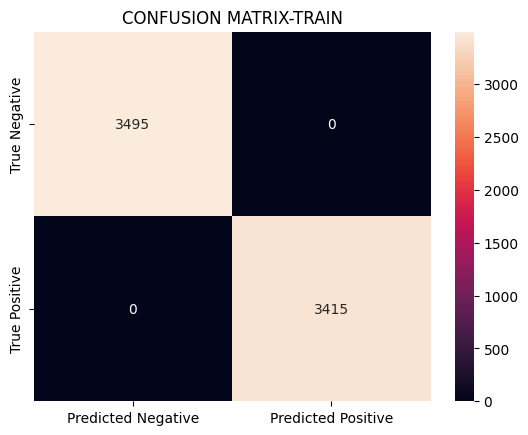

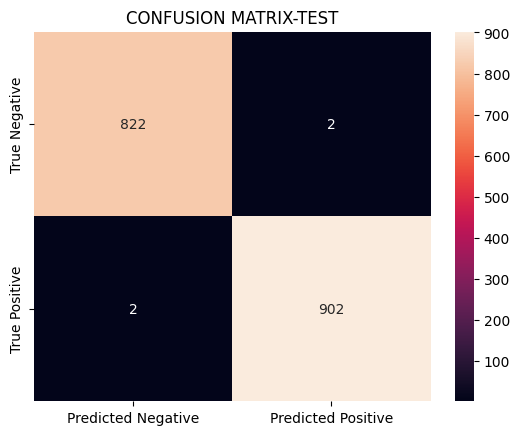

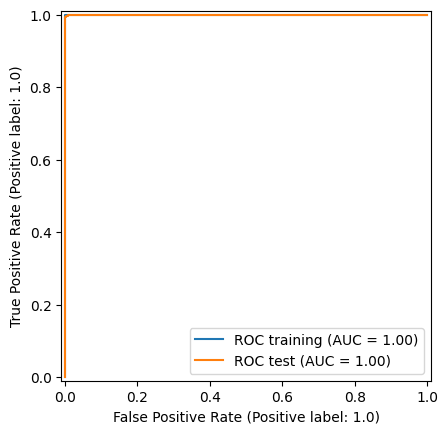

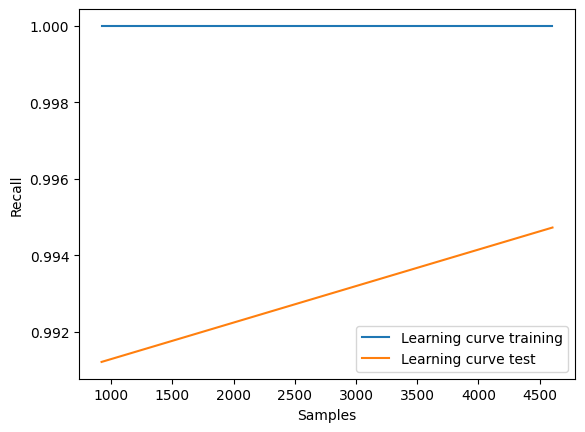

In [ ]:
#svm model (now it returns also the probability of classification)
#NOTE: although grid search returns C=0.1, the value 0.01 is adopted, since the model tends to overfit.
svm=SVC(kernel='linear', C=0.01, probability=True)
svm.fit(x_train_tot, y_train_tot) #fit on complete training set
evaluate_model(x_train_tot, y_train_tot, x_test, y_test, svm, 'TEST', learning_c=True) # model evaluation on train and test sets

Dall'analisi delle metriche per il modello svm, si nota come questo performi 'perfettamente' sia su train che su test. Questo generalmente non è un buon segno, tanto che si è cercato sia con features di HOG meno risolute, sia con PCA di migliorare la situazione, senza però apparente successo. Forse un dataset più abbondante/variegato potrebbe portare a risultati diversi, ma dato che nell'estrazione di volti il modello si comporta relativamente bene (si veda dopo), si procede con questo assetto.

###**Sliding window**
Una volta allenato il modello di classificazione, questo viene applicato per la ricerca di volti in immagini più generali di quelle del training. In particolare, nel training il modello ha incontrato solo volti singoli, mentre ora si vuole applicarlo a immagini che possono contenere più volti. Per fare questo, si considera una porzione di codice implementato in [[13](https://github.com/SamPlvs/Object-detection-via-HOG-SVM/blob/master/README.md)], dove una finestra attiva grande quanto la finestra su cui è stato allenato l'SVM (cioè 128x256 pixels) viene fatta scorrere sulla nuova immagine, che può avere dimensioni qualsiasi. Nello scorrere sulle varie porzioni di immagine da analizzare, l'SVM viene applicato in tale finestra per verificare la presenza di un volto. Nel caso affermativo il rettangolo della finestra attiva viene evidenziato e raffigurato sulla figura originale per incorniciare il volto trovato, insieme allo score di classificazione.

###**Approccio a piramide**

Dato che la finestra attiva ha dimensioni fisse, mentre i volti di un immagine generica possono essere grandi a piacere, si considera un approccio a piramide: l'immagine originale viene analizzata con la finestra attiva, poi viene riscalata e rianalizzata, e così via. In tal modo la finestra attiva copre regioni di grandezza diversa, in modo da rilevare volti di diversa misura.

###**Padding**

Nello scorrere la finestra attiva sull'immagine da analizzzare, può succedere che nelle regioni di bordo la finestra attiva esca fuori dalla dimensione effettiva dell'immagine. Nel codice originale queste regioni erano semplicemente scartate, mentre nella mia implementazione si cerca di sfruttarle. Per fare questo, si padda l'immagine originale per 'estenderla' su tutta la finestra attiva nel caso di regioni di bordo. Il padding è effettuato inserendo i pixels mancanti con valore zero. La regione di immagine originale su cui si effettua il padding viene inserita effettivamente nell'analisi solo se la regione con padding è minore del 40% della regione totale della finestra attiva, per evitare regioni totalmente fuori dall'immagine originale, e quindi con scarso contenuto informativo.

###**Score di classificazione**

Una volta che la finestra attiva classifica una data regione come contenente un volto, quest'ultimo è accettato solo se la classificazione aviene con sufficiente grado di confidenza. In particolare, la classificazione con SVM nel caso di kernel lineare definisce un iperpiano di separazione tra le classi che rispetta una equazione del tipo:

\begin{equation}
score=w^T\cdot x+b
\end{equation}
dove $w^T$ è il vettore di pesi, $x$ quello delle features e $b$ è lo scalare bias. Classificazioni con $score>0$ saranno appartenenti alla classe positiva, mentre con $score< 0$ classe negativa. Nel validare il rilevamento di volti, si considerano solo i volti con $score>0.95$, per evitare falsi positivi e per mitigare il problema della ridondanza già menzionato, che sarà approfondito a breve.

###**Ridondanza: due approcci di gestione**

Quando in una data immagine sono presenti volti, data l'applicazione della piramide di riscalature, succede che un volto sia rilevato più volte ma con rettangoli di dimensioni diverse. Questo è il probelma della ridondanza. La soluzione originariamente proposta nel repository GitHub da cui ho tratto ispirazione, era applicare un 'non max suppression', che ha proprio lo scopo di eliminare le ridondanze. Tale approccio però non ha dato buoni risultati con il mio modello e per questo l'ho sostituito con due approcci differenti.

Nel primo, creato a mano da me, si considerano ridondanti due rettangoli se questi hanno angolo sinistro superiore vicino entro una certa soglia e hanno aree confrontabili entro certi limiti. Questo criterio geometrico non considera lo score con cui ciascun rettangolo è classificato come positivo (oltre lo score soglia usato a priori, menzionato in precedenza). Infatti, una soglia di score con lo scopo di eliminare ridondanza avrebbe valenza globale su tutti i volti rilevati, e potrebbe da un lato escludere volti indipendenti rilevati, e dall'altro potrebbe comunque portare a ridondanza perchè sul volto i-esimo si potrebbero avere due rettangoli molto sicuri. Per questo si sceglie il criterio geometrico, perchè distingue volti diversi ed evita ridondanza.

Oltre il criterio geometrico, si testa anche un approccio basato sul clustering, in particolare utilizzando il modello DBSCAN [[14](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)]. In tal senso, DBSCAN si occupa di indentificare i clusters corrispondenti a volti diversi, per poi considerare su ognuno solo il rettangolo con score di classificazione maggiore. Infatti DBSCAN non necessita di inserire a priori il numero di clusters da rintracciare, ma trova i clusters come aree sovradense di punti (nel nostro caso i punti sono i centri dei vari rettangoli), associando i punti ad ogni cluster in base ad una distanza soglia tra punti vicini, eps.
Questo approccio risulta sicuramente più pulito e diretto del precedente, ed è utile perchè non dovendo specificare a priori il numero di clusters, non serve far sapere con anticipo al modello quanti volti troverà, ma sarà esso stesso a darci questa informazione.

Infine, si studierà anche il metodo che implementa la cascata di Haar per confronto in termini di tempo impiegato per il rilevamento e risorse RAM. Tutti gli approcci restituiranno le coordinate dei volti rilevati.

Per semplificare la lettura logica del codice, di seguito sono ripotate le principali funzioni implementate con il loro scopo:

- rectangle_identification: idenditifica i rettangoli contenenti volti nelle immagini, applicando la funzione sliding_window.
- rectangle_selection: seleziona i rettangoli con il metodo geometrico
- rectangle_selection_clustering: seleziona i rettangoli con il metodo del clustering

In [ ]:

def sliding_window(img, stepSize, windowSize):
    '''
    The function slides the active window on the input image, looking for faces.

    Args:
        - image (np.ndarray): input image to process
        - stepSize (int): step to shift the window on the image (in n. of pixels)
        - windowSize (tuple): width and height of the active window (in n. of pixels)
    '''
    # slide a window across the image
    for y in range(0, img.shape[0], stepSize): # loops over y and x directions
        for x in range(0, img.shape[1], stepSize):
            # yield the current window
            yield (x, y, img[y: y + windowSize[1], x:x + windowSize[0]])




def rectangle_identification(img_orig, decision_bound, windowSize, downscale, scaler, svm):
    '''
    The function idendifies possible faces in the input image using the slicing window technique
    in combination with the pyramid approach, to build rescaled verions of the original image.

    Args:
        - img_orig (obj PIL.Image): input image to analyze
        - decision_bound (float): threshold distance to validate positive classifications (which have distances from the decision hyperplane >=0)
        - windowSize (tuple): width and height of the active window (in n. of pixels)
        - downscale (float): factor to downscale the input image at each pyramid step
        - scaler (StandardScaler obj): the standardizer already fitted on train set
        - svm (SVM obj): the svm model already fitted on train set
    '''
    img_copy=img_orig.copy() # copy creation
    img = img_copy.convert("L") #greyscale convertion
    img = np.array(img) #np array convertion

    #window dimensions
    winW, winH=windowSize
    scale=0 #scale encodes the pyramid step
    detections = [] # empty list to store face detections
    # Apply sliding window:
    for resized in pyramid_gaussian(img, downscale=downscale): # loop over each resized version of the input image
        print(resized.shape)
        if resized.shape[0]<winH or resized.shape[1]<winW: # if resized image has dimensions smaller than the active window, break the pyramid
            break
        # loop over the sliding window for each resized copy
        for (x,y,window) in sliding_window(resized, stepSize=5, windowSize=windowSize):

          # PADDING
          # if the window does not meet our desired window size, padding is applied if the padded region is smaller than 40% of the entire window,
          # otherwise, the region is not considered.
          if window.shape[0] != winH or window.shape[1] !=winW:
              pad_h = winH - window.shape[0] # height padding
              pad_w = winW - window.shape[1] # width padding
              if (pad_h/window.shape[0]>0.4) or (pad_w/window.shape[1]>0.4): #if padded region>40% of the window, region neglected
                  continue
              else:
                  window = np.pad(window, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=0) #if padded region < 40% of the window,
                                                                                                     #region considered

          # extract HOG features from the window captured
          #NOTE: the HOG features extractor has the same hyperparameters used to train svm
          fds = hog(window, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm='L2-Hys', )

          fds = fds.reshape(1, -1) # reshape the image to match svm requirements
          #standardizer and pca applications
          fds=scaler.transform(fds)
          fds=pca.transform(fds)
          pred = svm.predict(fds) # use the svm model to make a prediction on the HOG features extracted from the window

          if pred == 1: # in case of positive classification (faces present)
              if svm.decision_function(fds)[0] > decision_bound: #only confirm the predictions with distance from the decision boundary > decision_bound
                  print("Detection:: Location -> ({}, {})".format(x, y))
                  score = svm.decision_function(fds)[0]
                  print("Scale ->  {} | Confidence Score {} \n".format(scale,score))
                  detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), score,   # create a list of all the predictions found
                                      int(windowSize[0]*(downscale**scale)),
                                        int(windowSize[1]*(downscale**scale))))
        scale+=1

    sc = [score for (x, y, score, w, h) in detections]
    print("detection confidence scores: \n", sc)

    return detections


########################################################################################

#RAM and execution time analysis
process = psutil.Process(os.getpid())
peak_memory = 0 #starting value to measure RAM peak due to following process
start_svm=time.time() # starting time

#New Image to classify
path_test="/content/drive/MyDrive/FaceDetection/selfie.png"
img_original=Image.open(path_test)

#identify rectangles
tot_detections=rectangle_identification(img_original, 0.95, (128,256), 1.5, scaler, svm)

peak_memory = max(peak_memory, process.memory_info().rss) # RAM peak due to the previous function execution
end_svm=time.time() # end time of previous function execution
print('\n\n-------------------- Used Resources ----------------------')
print(f"\nPeak RAM: {peak_memory/1024**3:.2f} GB")
print(f'Execution time SVM [minutes]: {(end_svm-start_svm)/60:.2f}\n')

(407, 735)
Detection:: Location -> (530, 20)
Scale ->  0 | Confidence Score 0.9635650760324137 

Detection:: Location -> (535, 20)
Scale ->  0 | Confidence Score 0.9807513396881213 

Detection:: Location -> (530, 25)
Scale ->  0 | Confidence Score 1.3410508128547196 

Detection:: Location -> (535, 25)
Scale ->  0 | Confidence Score 1.587693717577187 

Detection:: Location -> (540, 25)
Scale ->  0 | Confidence Score 1.2178908485146729 

Detection:: Location -> (530, 30)
Scale ->  0 | Confidence Score 1.4313396455509082 

Detection:: Location -> (535, 30)
Scale ->  0 | Confidence Score 1.6048278365189501 

Detection:: Location -> (540, 30)
Scale ->  0 | Confidence Score 1.220954946271602 

Detection:: Location -> (135, 35)
Scale ->  0 | Confidence Score 1.2356880510918844 

Detection:: Location -> (140, 35)
Scale ->  0 | Confidence Score 1.2009533769215965 

Detection:: Location -> (530, 35)
Scale ->  0 | Confidence Score 1.04709209229745 

Detection:: Location -> (535, 35)
Scale ->  0 |


Found faces coord list:
 [(530, 20, 658, 276), (135, 35, 263, 291), (220, 75, 348, 331), (225, 190, 353, 446), (337, 30, 529, 414), (150, 75, 342, 459), (52, 105, 244, 489)]
N. of faces found: 7



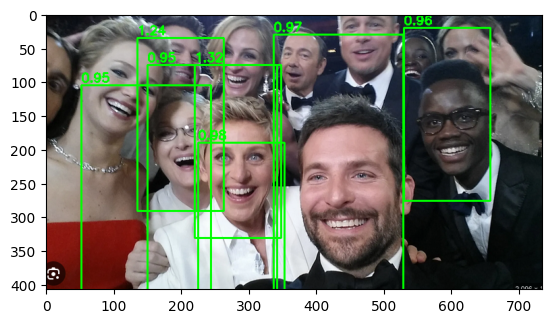

In [ ]:
def rectangle_plotting(rectangles, img_original):
    '''
    The function plots rectangles including faces, as recovered by different algorithms.

    Args:
        - rectangles (list of tuples): each tuple stores (x,y,score,w,h) of each face detection (x,y: left upper corner of the rectangle)
        - img_original (np.ndarray): numpy version of the original image on which rectangles are shown
    '''

    #loop over list of rectangles
    for (xA, yA, score, w, h) in rectangles:
        xA, yA, w, h = int(xA), int(yA), int(w), int(h) # opencv requires int coordinates. This row ensures that.
        cv2.rectangle(img_original, (xA, yA), (xA+w, yA+h), (0,255,0), 2) # rectangles are depicted in green color

        #adding a label with the score on the face rectangle
        title = f"{score:.2f}"  # the label
        cv2.putText(img_original,
                  title,
                  (xA, yA - 5), # text collocation
                  cv2.FONT_HERSHEY_SIMPLEX, # font type
                  0.6, # text dimension
                  (0, 255, 0), # text color in BGR (green in this case)
                  2  # text thickness
        )
    plt.imshow(img_original)



def rectangle_coord_list(rectangles):
    '''
    The function outputs the coordinates and the number of rectangles found in a given image.

    Args:
        - rectangles (list of tuples): each tuple stores (x,y,score,w,h) of each face detection (x,y: left upper corner of the rectangle)
    '''
    faces_coord=[] # empty coordinates list
    for (xA, yA, score, w, h) in rectangles: #extraction of coordinates
        xB=xA+w
        yB=yA+h
        coord_tuple=(int(xA),int(yA),int(xB),int(yB)) # coordinates tuple
        faces_coord.append(coord_tuple)
    print(f"\nFound faces coord list:\n {faces_coord}")
    print(f"N. of faces found: {len(faces_coord)}\n")



def rectangle_selection(rectangles, img_orig, dist_val=10, lower_ratio=0.2, upper_ratio=2.):
    '''
    The function selects the meaningful rectangles after HOG+SVM, which tends to produce redundant face detections.
    To do this it compares the distance between the left upper corners and the area values of two rectangles: if both measures respect
    the given thresholds, the rectangles are considered to point at the same face, so one of the two is neglected.

    Args:
        - rectangles (list of tuples): each tuple stores (x,y,score,w,h) of each face detection (x,y: left upper corner of the rectangle)
        - img_orig (obj PIL.Image): original image
        - dist_val (int): threshold pixel distance between left upper corners of rectangles
        - lower_ratio (float): minimum threshold of the area ratio
        - upper_ratio (float): maximum threshold of the area ratio
    '''
    # original image copy creation
    img=img_orig.copy()
    img=np.array(img)

    if len(rectangles)==0: # in case of no faces found, an empty list is returned
        print(f"\nFound faces coord list:\n {rectangles}")
        print(f"N. of faces found: 0\n")
        return

    delete_indices=set() # empty set to store indices of rectangles to be neglected
    for i in range(len(rectangles)): # rectangles contains tuples with (xA, yA, score, w, h)
       xi,yi,_,wi,hi=rectangles[i]
       coord_i=np.array([xi, yi]) # left upper corner coordinates
       area_i=wi*hi #area
       for j in range(i+1,len(rectangles)): # same loop above, but for elements from the i-th +1
          xj,yj,_,wj,hj=rectangles[j]
          coord_j=np.array([xj, yj])
          area_j=wj*hj
          dist=np.linalg.norm(coord_i-coord_j) # corners distance
          ratio=area_i/area_j  # area ratio
          if dist<dist_val and (lower_ratio <= ratio <= upper_ratio): #conditions to neglect a rectangle
              delete_indices.add(j)
    rectangles=np.delete(rectangles, sorted(delete_indices), axis=0) # deleting superflous rectangles

    # output rectangles
    rectangle_coord_list(rectangles)  # printing selected rectangles coordinates
    rectangle_plotting(rectangles, img) # plotting selected rectangles

######################################################################################

# selection between redundant rectangles
rectangle_selection(tot_detections, img_original)


Found faces coord list:
 [(535, 30, 663, 286), (135, 45, 263, 301), (225, 85, 353, 341), (225, 190, 353, 446), (345, 45, 537, 429), (157, 75, 349, 459), (60, 105, 252, 489)]
N. of faces found: 7



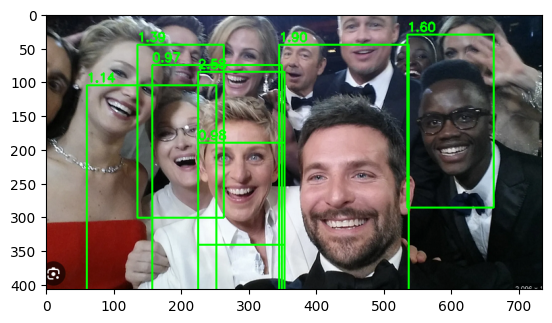

In [ ]:
def rectangle_selection_clustering(rectangles, img_orig, dist_centers=30):
    '''
    The function selects the meaningful rectangles after HOG+SVM, which tends to produce redundant face detections.
    To do this it adopts a clustering model to group rectangles according to their spatial position and then selecting the best score one.

    Args:
        - rectangles (list of tuples): each tuple stores (x,y,score,w,h) of each face detection (x,y: left upper corner of the rectangle)
        - img_orig (obj PIL.Image): original image
        - dist_centers (int): maximum threshold distance (in pixels) between two rectangle centers in order to be associated with the same cluster
    '''

    # original image copy
    img=img_orig.copy()
    img=np.array(img)

    if len(rectangles)==0: # in case of no faces found, an empty list is returned
        print(f"\nFound faces coord list:\n {rectangles}")
        print(f"N. of faces found: 0\n")
        return

    rectangles=np.array(rectangles) # rectangles list in numpy array trasformation
    rects_centers=np.array([[x + w/2, y + h/2] for (x, y, _, w, h) in rectangles]) # rectangle centers extraction, to cluster according to them

    #clustering model
    db=DBSCAN(eps=dist_centers, min_samples=1) # eps sets the maximum threshold distance to associate two rectangles to the same cluster
    db.fit(rects_centers) # fit on rectangle centers
    labels=db.labels_ # a specific label is assigned to rects of a given cluster

    final_rects=[] # list to store selected rectangles
    for label in np.unique(labels): # loop over clusters
        cluster = rectangles[labels==label] # rectangles selection belonging to a given cluster through a boolean mask
        # in the given cluster only the best score rectangle is considered
        best_rectangle = max(cluster, key=lambda r: r[2])
        final_rects.append(best_rectangle)

    # output rectangles
    rectangle_coord_list(final_rects) # selected rectangles coordinates
    rectangle_plotting(final_rects, img) # selected rectangles plotting



######################################################################

# rectangle selection through clustering model
rectangle_selection_clustering(tot_detections, img_original)

Come si può notare sia selezione geometrica che basata su clustering, producono ancora diverse sovrapposizioni dovute al modo in cui la selezione è implementata, e oltre ciò il modello HOG+SVM in generale produce rettangoli anche dove i volti sono parziali o in combinazione.

#**Haar cascade**

Come anticipato, l'ultimo approccio testato è quello della cascata di Haar. Questo si basa sull'analizzare le diverse regioni di un'immagine in cerca di pattern specifici di intensità, applicando un insieme di classificatori, tali che se solo uno di essi non rileva nulla in una certa zona, questa zona veine esclusa dall'analisi e non passata ai classificatori successivi, risparmiando tempo. Il modello è disponibile in forma preaddestrata in OpenCV. In particolare si adotta il modello preaddestrato apposito per rilevamento di volti frontali, prendendo spunto da quanto riportato in [[15](https://github.com/Malayanil/FaceDetectionHC/blob/master/face_detect_static.py)]. Si potrà notare come questo approccio sia un approccio 'real time', quindi molto veloce, a differenza degli approcci precedenti. Questo è largamente dovuto alla differenza di implementazione degli approcci con Hog rispetto ad Haar. Infatti, la cascata di Haar in OpenCV è scritta in C++, il che la rende molto più veloce rispetto ad un codice Python. In termini di RAM le risorse necessarie sembrano essere circa le stesse di HOG.


Found faces coord list:
 [(334, 30, 406, 102), (578, 26, 652, 100), (240, 25, 329, 114), (32, 39, 148, 155), (148, 128, 263, 243), (222, 162, 350, 290), (351, 169, 526, 344)]
N. of faces found: 7



-------------------- Used Resources ----------------------
Peak RAM: 1.96 GB
Execution time Haar [minutes]: 0.00



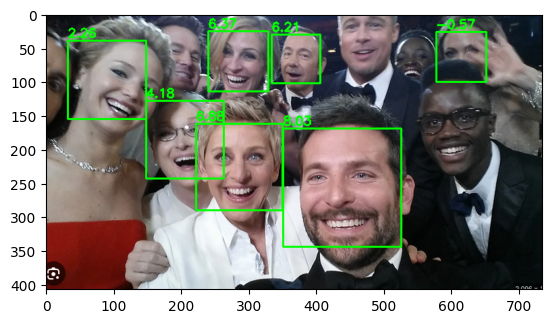

In [ ]:
def haar_cascade(img_orig, verbose=True):
    '''
    The function performs the Haar cascade algorithm to find faces in an input image.

    Args:
        - img_orig (obj PIL.Image): numpy array representing the input image
        - verbose (bool): flag to enable verbose mode
    '''

    # numpy version of an input image
    img=img_orig.copy()
    img=np.array(img)

    # importing pretrained haar cascade, frontal face verson
    haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # evaluating time and RAM performances
    process = psutil.Process(os.getpid())
    peak_memory = 0
    start_haar=time.time()

    # gray scale convertion
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # haar face detection
    faces, rejectLevels, levelWeights = haar.detectMultiScale3(
    gray_img, # grey scale image
    scaleFactor=1.1, # scale factor to reduce orinal image shape at each pyramid step
    minNeighbors=2, # min number of redundant detections to confirm face presence
    outputRejectLevels=True, # returns internal steps of the cascade
    minSize=(40, 40) # min shape of faces to detect
    )

    # building rectangles and score
    rectangles=[(int(x), int(y), float(score), int(w), int(h)) for (x,y,w,h), score in zip(faces,levelWeights)]

    # output rectangles
    rectangle_coord_list(rectangles)
    rectangle_plotting(rectangles, img)

    peak_memory = max(peak_memory, process.memory_info().rss)
    end_haar=time.time()

    # verbosity, to output performance estimators
    if verbose==True:
      print('\n\n-------------------- Used Resources ----------------------')
      print(f"Peak RAM: {peak_memory/1024**3:.2f} GB")
      print(f'Execution time Haar [minutes]: {(end_haar-start_haar)/60:.2f}\n')


#############################################

haar_cascade(img_original) # haar cascade application


*  Si nota subito come Haar cascade sia enormemente più
rapido. Sia perchè scritto in C++ come accennato, sia perchè fa uso dell'Integral Image, tecnica usata per calcolare la somma di pixel vicini, portando a rilevare volti con elevata rapidità.

*  Si può anche notare come Haar riesca a rilevare volti di dimensioni diverse e con rotazione del profilo. Inoltre la ridondanza dei volti è ridotta a zero e il posizionamento dei riquadri è corretto su ogni volto.


* Si può infine osservare come sia HOG che Haar utilizzino una RAM < 2 Gb, il che li rende adatti per girare anche su dispositivi con risorse hardware limitate. In termini di tempo di elaborazione, sicuramente Haar risulta più performante.

###**Confronto approcci su immagini di diverso tipo**

Avendo visto le performance di HOG+SVM e di Haar sull'immagine di gruppo precedente, adesso si vuole vedere come i due approcci lavorino su immagini di diversa natura e con un certo grado di ambiguità. Per questo saranno testati con immagini di paesaggi, di animali e di persone in pose diverse.

In [ ]:

def model_comparaison(img_path, scaler, svm):
    '''
    The function implements face detection calling both Hog+svm and Haar cascade approaches.
    Args:
        - img_path (str): url of the image to analyze
        - scaler (obj): StandardScaler object
        - svm (obj): SVM object
    '''
    #image opening
    img_original=Image.open(img_path)
    print('\n\n\n---------------------- HOG ----------------------------')
    # Hog + svm detection
    tot_detections=rectangle_identification(img_original, 0.95, (128,256), 1.5, scaler, svm)
    # Rectangle selection
    rectangle_selection_clustering(tot_detections, img_original)
    plt.show()

    print('\n---------------------- HAAR ----------------------------')
    # Haar cascade
    haar_cascade(img_original, verbose=False)
    plt.show()
################################################################

# general testing (Hog+svm VS Haar)
#list of image paths to test
path_list=['/content/drive/MyDrive/FaceDetection/natura.jpg',
           '/content/drive/MyDrive/FaceDetection/uomo.jpeg',
           '/content/drive/MyDrive/FaceDetection/bradipo.jpg',
           '/content/drive/MyDrive/FaceDetection/coppia.jpg',
           '/content/drive/MyDrive/FaceDetection/uomini_di_colore.jpg']


###**Primo test: paesaggio**
L'immagine di un paesaggio viene passata sia al modello HOG+SVM che ad Haar. Entrambi non rilevano, correttamente, alcun volto.




---------------------- HOG ----------------------------
(354, 236)
(236, 158)
detection confidence scores: 
 []

Found faces coord list:
 []
N. of faces found: 0


---------------------- HAAR ----------------------------

Found faces coord list:
 []
N. of faces found: 0



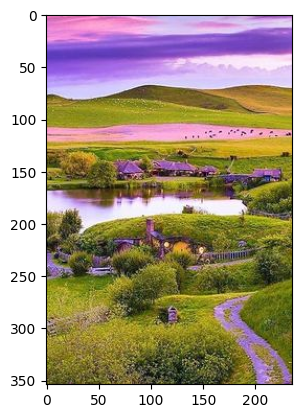

In [ ]:
# first test
model_comparaison(path_list[0], scaler, svm)


###**Secondo test: volto umano vicino al borso dell'immagine**

Nel secondo test si passa ai modelli un'immagine contenente un volto umano in posa da selfie, ma leggermente tagliato, perchè vicino al bordo. HOG+SVM riesce a rintracciare la presenza del volto, mentre Haar no.




---------------------- HOG ----------------------------
(290, 174)
Detection:: Location -> (70, 5)
Scale ->  0 | Confidence Score 1.0527534998996477 

Detection:: Location -> (70, 25)
Scale ->  0 | Confidence Score 1.0267402575523723 

Detection:: Location -> (70, 30)
Scale ->  0 | Confidence Score 1.060933907866098 

Detection:: Location -> (70, 35)
Scale ->  0 | Confidence Score 1.0352186142689055 

Detection:: Location -> (70, 40)
Scale ->  0 | Confidence Score 1.0471503133502291 

(194, 116)
detection confidence scores: 
 [np.float64(1.0527534998996477), np.float64(1.0267402575523723), np.float64(1.060933907866098), np.float64(1.0352186142689055), np.float64(1.0471503133502291)]

Found faces coord list:
 [(70, 30, 198, 286)]
N. of faces found: 1



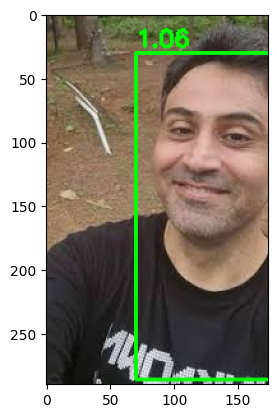


---------------------- HAAR ----------------------------

Found faces coord list:
 []
N. of faces found: 0



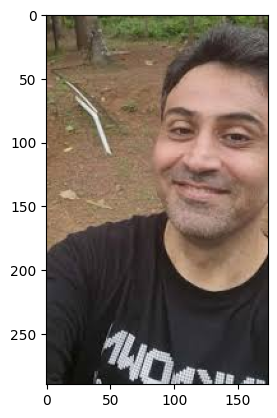

In [ ]:
# second test
model_comparaison(path_list[1], scaler, svm)

###**Terzo test: animale (bradipo)**
Nel terzo test si valuta se i modelli si lascino ingannare da un 'volto' animale, in particlare di un bradipo che ha una fisionomia di base simile a quella umana. Si nota come HOG+SVM predice correttamente l'assenza di volti umani, mentre Haar si lascia ingannare, ma non dal bradipo, bensì dalla vegetazione.




---------------------- HOG ----------------------------
(200, 356)
detection confidence scores: 
 []

Found faces coord list:
 []
N. of faces found: 0


---------------------- HAAR ----------------------------

Found faces coord list:
 [(219, 46, 271, 98)]
N. of faces found: 1



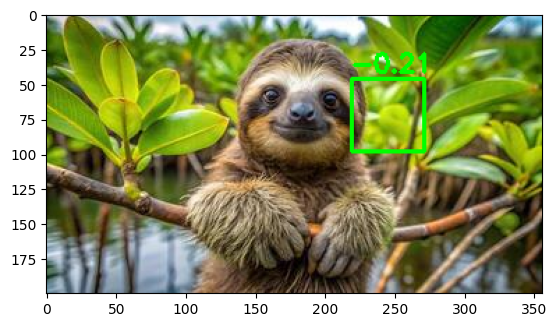

In [ ]:
# third test
model_comparaison(path_list[2], scaler, svm)

###**Quarto test: selfie di coppia**

In questo test si valutano i modelli su un selfie di coppia. Si nota come il modello HOG+SVM predica bene il volto femminile, ma poi preveda anche presenza di volti dove questi non sono presenti. Questo è dovuto sia all'abilità di HOG+SVM di riconoscere volti, sia al fatto che il selettore di rettangoli basato sul clustering si basa sulla distanza massima che due rettangoli devono avere per essere considerati ridondanti (e quindi indicanti lo stesso volto). In questa immagine le dimensioni di base dei volti sono molto grandi e quindi la condizione di distanza tra rettangoli settata a partire dalla foto di gruppo presentata nelle sezioni precedenti, non va più bene, perchè si basa su una distanza caratteristica che va bene per immagini grandi e tanti volti, ma non va più bene per immagini più piccole e volti davvero in primo piano. Inoltre il volto maschile non viene captato.

L'approccio di Haar si concentra molto bene sul volto femminile, non producendo rettangoli fuori posizione. Però risulta anch'esso in difficoltà sulla previsione del volto maschile. L'uomo in questione è di colore, proprio come quello presente nel selfie di gruppo analizzato precedentemente. Anche lì Haar non era stato in grado di rilevare il volto (mentre HOG sì). Questo è forse dovuto alla transizione in scala di grigi e al fatto che il modello si basi sul gioco luci/ombre per trovare i pattern (sebbene anche HOG si basi sulla variazione di intensità dei pixels), ma su un volto di colore (o con illuminazione uniforme) questi pattern risultano meno chiari ed immediati. Inoltre potrebbe giocare un ruolo anche l'inclinazione verticale del volto maschile.





---------------------- HOG ----------------------------
(500, 300)
Detection:: Location -> (145, 110)
Scale ->  0 | Confidence Score 0.9974349858068354 

Detection:: Location -> (115, 180)
Scale ->  0 | Confidence Score 1.1505809013003878 

Detection:: Location -> (120, 180)
Scale ->  0 | Confidence Score 1.3413049442041964 

Detection:: Location -> (115, 185)
Scale ->  0 | Confidence Score 1.2342385264850824 

Detection:: Location -> (120, 185)
Scale ->  0 | Confidence Score 1.3886437542171537 

Detection:: Location -> (115, 190)
Scale ->  0 | Confidence Score 1.188833735013121 

Detection:: Location -> (120, 190)
Scale ->  0 | Confidence Score 1.1286536485204297 

Detection:: Location -> (60, 280)
Scale ->  0 | Confidence Score 1.2118640998251191 

Detection:: Location -> (65, 280)
Scale ->  0 | Confidence Score 1.002253933349691 

Detection:: Location -> (50, 285)
Scale ->  0 | Confidence Score 0.9667559560524062 

Detection:: Location -> (55, 285)
Scale ->  0 | Confidence Score 

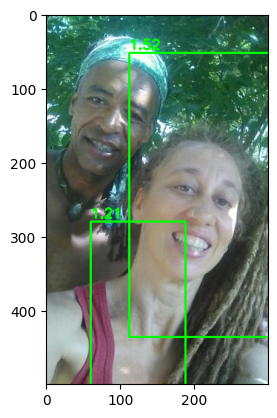


---------------------- HAAR ----------------------------

Found faces coord list:
 [(133, 185, 281, 333)]
N. of faces found: 1



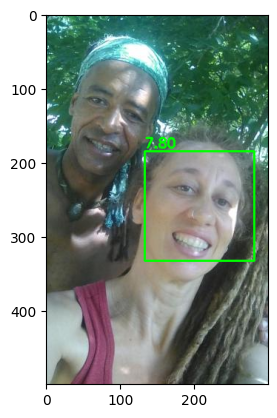

In [ ]:
# fourth test
model_comparaison(path_list[3], scaler, svm)

###**Ultimo test: uomini di colore**

Data la precedente difficoltà dei modelli nel prevedere correttamente volti di persone di colore, si testa direttamente il loro comportamento su una foto dove sono ritratte solo persone di colore. Si nota come HOG+SVM sbagli la previsione, non includendo nessun volto.

Dall'altro lato, Haar questa volta sembra essere in grado di recuperare alcuni volti, ma non tutti. La tesi secondo cui i volti di uomini di colore non sono ben rilevati non è ancora confermata. Sia perchè anche HOG+SVM non rileva i volti di colore in questo caso, sia perchè Haar sembra funzionare meglio. Inoltre guardando le previsioni di Haar ora, invece del colore della pelle, l'ostacolo al rilevamento è forse l'orientazione dei volti sulla destra, abbastanza inclinati ripsetto ai due predetti a sinistra. Questa difficoltà di Haar sull'orientazione potrebbe essere legata anche al modello specifico adottato.

Servirebbe un'analisi più approfondita per capire se c'è una effettiva difficoltà di previsione in base al colore della pelle, oppure questa difficoltà dipenda in generale solo da come il volto è illuminato (e quindi se sono presenti contrasti evidenti). Inoltre l'inclinazione dei volti potrebbe essere cruciale per la rivelazione o meno.




---------------------- HOG ----------------------------
(300, 450)
Detection:: Location -> (350, 90)
Scale ->  0 | Confidence Score 1.032326687840747 

Detection:: Location -> (355, 90)
Scale ->  0 | Confidence Score 1.180152949555432 

Detection:: Location -> (345, 95)
Scale ->  0 | Confidence Score 1.3271850095925948 

Detection:: Location -> (350, 95)
Scale ->  0 | Confidence Score 1.3789262787595753 

Detection:: Location -> (355, 95)
Scale ->  0 | Confidence Score 1.5202845797376614 

Detection:: Location -> (345, 100)
Scale ->  0 | Confidence Score 1.4952277298873538 

Detection:: Location -> (350, 100)
Scale ->  0 | Confidence Score 1.4443529107813045 

Detection:: Location -> (355, 100)
Scale ->  0 | Confidence Score 1.4042175737409919 

Detection:: Location -> (345, 105)
Scale ->  0 | Confidence Score 1.3857607988877052 

Detection:: Location -> (350, 105)
Scale ->  0 | Confidence Score 1.277221806105363 

Detection:: Location -> (355, 105)
Scale ->  0 | Confidence Score 1.

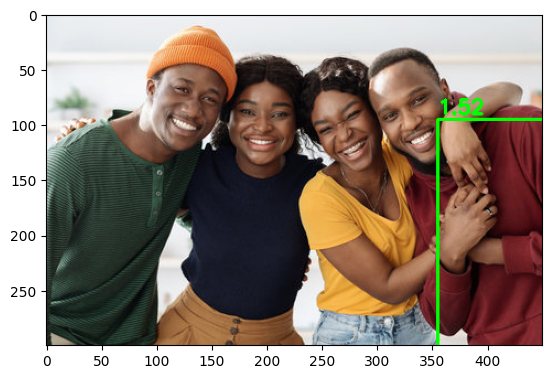


---------------------- HAAR ----------------------------

Found faces coord list:
 [(98, 27, 151, 80), (165, 64, 230, 129)]
N. of faces found: 2



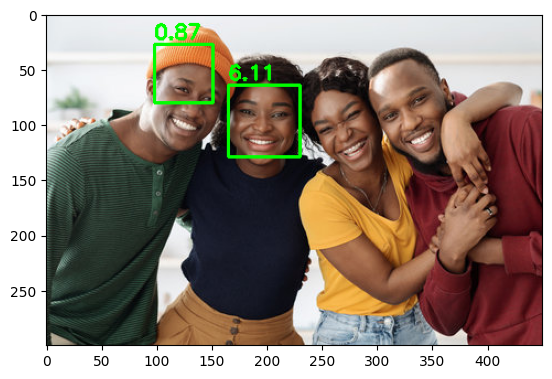

In [ ]:
# last test
model_comparaison(path_list[4], scaler, svm)

###**Addestramento finale su tutto il dataset per il modello HOG+SVM**

In [ ]:
#final training on the whole dataset
scaler=StandardScaler() #instantiation of standard scaler
pca=PCA(n_components=0.90) #instantiation of principal component analysis in order to reduce dimensionality of the hog features vector,
                           #preserving 90% of variance

x=np.array([data_augmentation(img) for img in x]) #apply the data_augmentation function

#HOG features extraction
x=hog_features_extractor(x)
print(f'\nx_train shape before PCA: {x.shape}')

# StandardScaler application
x=scaler.fit_transform(x)
#PCA application
x=pca.fit_transform(x)
print(f'\nx_train shape after PCA: {x.shape}')


x_train shape before PCA: (8638, 16740)

x_train shape after PCA: (8638, 2222)


In [ ]:
svm=SVC(kernel='linear', C=0.01, probability=True)
svm.fit(x, y) #fit on complete dataset

#saving model, scaler and pca for future applications, with joblib
best_model_dict={'scaler':scaler, 'pca':pca, 'model':svm} #dict storing trained svm, scaler and pca
dump(best_model_dict, 'best_model_dict.joblib') # saving the dict


['best_model_dict.joblib']

###**Conclusioni**

In questo progetto è stato affrontato un task di face detection, implementando a mano tutte le funzioni principali per il rilevamento dei volti secondo un approccio HOG+SVM. Nel contesto di tale approccio, si è notato come in generale la ridondanza sia un problema, discretamente affrontato includendo un algortimo di clustering. D'altro canto, HOG+SVM risulta lento nel calcolo e poco adatto ad approcci real time, a differenza dell'approccio Haar cascade, testato per confronto. Inoltre è emerso come la selezione dei volti con clustering (a parità di parametri di HOG) sia sensibile all'immagine specifica su cui si settano gli iperparametri per trovare i clusters. Questo indica la necessità di tarare la distanza massima tra rettangoli in modo dipendente, ad esempio, dalla dimensione generale dell'immagine, oppure applicando una batteria di clustering variando proprio la distanza massima. Questo dovrebbe rendere l'approccio meno dipendente dall'immagine campione su cui si tara.

Inoltre si è notato come una illuminazione particolarmente uniforme o una rotazione eccessiva del volto possano confondere i modelli di face detection, ma questi due punti necessitano di ulteriori approfondimenti, e nel caso di Haar, sono forse dipendenti in parte dallo specifico modello utilizzato.

Al termine delle analisi, il modello SVM addestrato su tutto il dataset è stato salvato tramite joblib, insieme allo scaler e alla pca utilizzati, inserendo tutto in un dizionario. Per future applicazioni basterà ricaricare il dizionario di oggetti già addestrati.

###**Riferimenti**
1. https://robotcopper.github.io/Machine_Learning/HoG_and_SVM
2. https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features

3. https://arxiv.org/abs/1406.2419
4. https://docs.opencv.org/4.x/d2/d99/tutorial_js_face_detection.html
5. https://medium.com/@utkrisht14/face-detection-using-haar-cascade-algorithm-267751b43240

6. https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset
7. https://www.kaggle.com/datasets/arnaud58/landscape-pictures

8. https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_hog.html
9. https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d
10. https://www.cs.utoronto.ca/~fidler/slides/CSC420/lecture17.pdf
11. https://stats.stackexchange.com/questions/562442/how-to-perform-data-augmentation-with-traditional-machine-learning-algorithms
12. https://www.warse.org/IJETER/static/pdf/file/ijeter244892020.pdf
13. https://github.com/SamPlvs/Object-detection-via-HOG-SVM/blob/master/README.md
14. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

15. https://github.com/Malayanil/FaceDetectionHC/blob/master/face_detect_static.py